In [11]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
import holidays
import random
from sklearn import metrics

Extraction of second floor electricity demand from the dataset.


In [12]:
DATASET_PATH = 'AVGpower-1.csv'
SAMPLES = 4

dataset = pd.read_csv(DATASET_PATH, sep=';', parse_dates=['DateTime'])
dataset.drop(columns=['AvgT', 'AvgH'], inplace=True)
secondFloorData = dataset[dataset['CbTagName']=='CB Second Floor'].set_index("DateTime")
secondFloorData.drop('CbTagName', axis=1, inplace=True)
secondFloorData['DateTime'] = secondFloorData.index
secondFloorData.head(10)

,AvgP,DateTime
DateTime,,
2017-02-06 00:00:00,0,2017-02-06 00:00:00
2017-02-06 17:00:00,80,2017-02-06 17:00:00
2017-02-06 17:15:00,0,2017-02-06 17:15:00
2017-02-06 17:30:00,0,2017-02-06 17:30:00
2017-02-06 17:45:00,82,2017-02-06 17:45:00
2017-02-06 18:00:00,0,2017-02-06 18:00:00
2017-02-06 18:15:00,0,2017-02-06 18:15:00
2017-02-06 18:30:00,78,2017-02-06 18:30:00
2017-02-06 18:45:00,0,2017-02-06 18:45:00


Data from february 2017 are rare, so they are deleted.

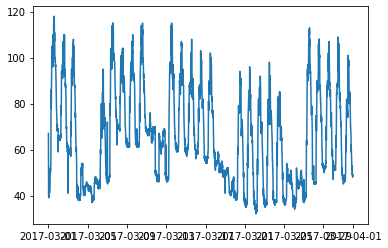

Missing values of the first week:0


In [13]:
%matplotlib inline
secondFloorData2017 = secondFloorData[(secondFloorData['DateTime'].dt.year == 2017) & (secondFloorData['DateTime'].dt.month >=3)]
secondFloorData2018 = secondFloorData[secondFloorData['DateTime'].dt.year >= 2018]
secondFloorData = pd.concat([secondFloorData2017, secondFloorData2018])
secondFloorData = secondFloorData.set_index('DateTime')
secondFloorData['DateTime'] = secondFloorData.index
secondFloorData.head(20)
firstValues = secondFloorData2017[secondFloorData2017["DateTime"].dt.month <4]
dates = firstValues['DateTime'].to_numpy()
powerDemand = firstValues['AvgP'].to_numpy()
plt.plot(dates, powerDemand)
plt.show()

MissingDates = 0
for date in pd.date_range(start='2017-03-01', end='2017-03-08', freq='15m'):
    if date not in firstValues:
        MissingDates +=1
print('Missing values of the first week:' + str(MissingDates))

All the missing data are introduced with a Nan value.

In [14]:
new_row = {name:[] for name in secondFloorData.columns}

for date in pd.date_range(start='2017-03-01', end=secondFloorData['DateTime'].max(), freq='15Min'):
    if date not in secondFloorData.index:
        new_row['DateTime'].append(date)
        new_row['AvgP'].append(np.nan)
secondFloorData = pd.concat([secondFloorData, pd.DataFrame(new_row)])
secondFloorData = secondFloorData.set_index("DateTime")
secondFloorData.sort_index(inplace=True)

All the Nan values are replaced with values of a week before.

In [15]:
for i in range(672, len(secondFloorData)):
    if np.isnan(secondFloorData.iloc[i].AvgP):
        secondFloorData.iloc[i] = secondFloorData.iloc[i-672]
secondFloorData['DateTime'] = secondFloorData.index

Finding holidays dates

In [16]:
holidayDays = []
for date in holidays.Italy(years=[2017,2018,2019]).items():
    holidayDays.append(date[0])

Building a training set and separating holidays samples from normal samples.
- trainingset is a dictionary which keys are all the days of the dataset, and values are samples of the specified day.
- allSamples is a list of all the samples.
- holidaysSamples is a dictionary which keys are dates of weekend days or holidays, and values are samples of the specified day.
- atHomeSamples is a list of the values of holidaysSamples
- workingDaysSamples is a dictionary which keys are days of work, and values are samples of the specified day.
- atWorkSamples is a list of values of workingDaysSamples


In [17]:
daySpan = SAMPLES * 24
trainingSet = {}
holidaysSamples = {}
workingDaysSamples = {}
row = 0
atHomeSamples = []
atWorkSamples = []
allSamples = []
for date in pd.date_range(start='2017-03-01', end='2019-04-09', freq='1d'):
    day = secondFloorData[row : row + daySpan]
    samplesPerDay = day["AvgP"].to_numpy()
    samples = []
    for index in range(24):
        firstIndex = index * SAMPLES
        samples.append(samplesPerDay[firstIndex : firstIndex + SAMPLES].mean())
    if date.day_of_week == 5 or date.day_of_week == 6 or date in holidayDays:
        holidaysSamples[str(date).split()[0]] = samples
        atHomeSamples.append(samples)
    else:
        workingDaysSamples[str(date).split()[0]] = samples
        atWorkSamples.append(samples)
    trainingSet[str(date).split()[0]] = samples
    allSamples.append(samples)
    row += daySpan

Here is a representation of working days samples:

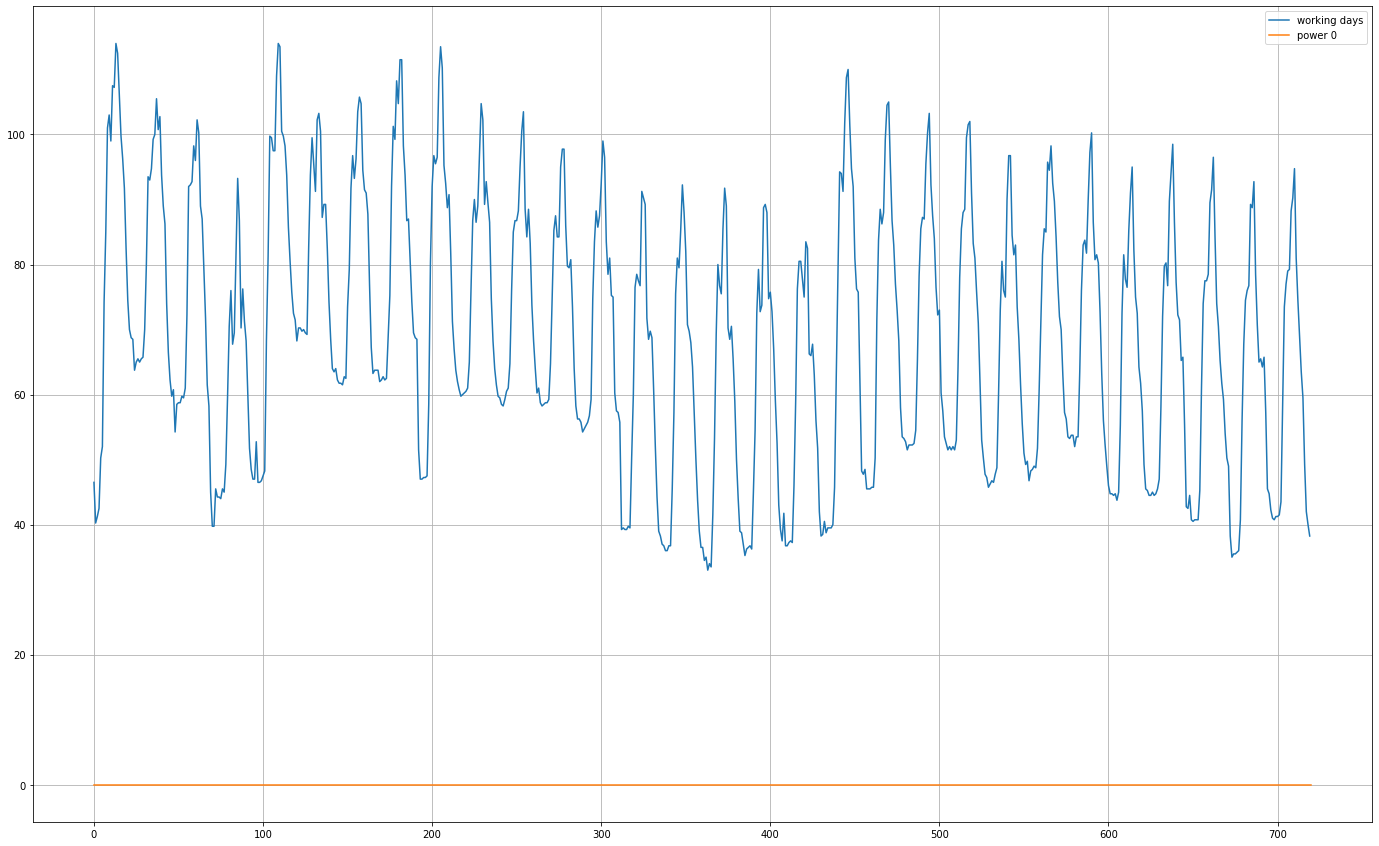

In [18]:
workingDaysToPrint = np.array([])
SPAN = 30
START = 0
for day in range(SPAN):
    workingDaysToPrint = np.append(workingDaysToPrint, atWorkSamples[START + day])

fig, ax = plt.subplots(figsize=(24,15))
ax.plot([x for x in range(workingDaysToPrint.size)], workingDaysToPrint, label='working days')
ax.plot([0, SPAN * 24], [0, 0], label='power 0')
ax.grid()
ax.legend()
plt.show()

Now it's to time divide the sets in training sets and testing sets. We set the size of training set to 80% of the size of all the samples.

In [19]:
PERCENTAGE = 0.8

random.shuffle(atHomeSamples)
#random.shuffle(atWorkSamples)
#random.shuffle(allSamples)

trainingHolidays = []
testHolidays = []
trainingWorkDays = []
testWorkDays = []
trainingSamples = []
testingSamples = []

trainingSize = int(len(atHomeSamples) * 0.8)
for index in range(trainingSize):
    trainingHolidays.append(atHomeSamples[index])
for index in range(trainingSize, len(atHomeSamples)):
    testHolidays.append(atHomeSamples[index])

trainingSize = int(len(atWorkSamples) * 0.8)
for index in range(trainingSize):
    trainingWorkDays.append(atWorkSamples[index])
for index in range(trainingSize, len(atWorkSamples)):
    testWorkDays.append(atWorkSamples[index])

trainingSize = int(len(allSamples) * 0.8)
for index in range(trainingSize):
    trainingSamples.append(allSamples[index])
for index in range(trainingSize, len(allSamples)):
    testingSamples.append(allSamples[index])
print('training workdays dataset size :' + str(len(trainingWorkDays)))
print('training holidays dataset size :' + str(len(trainingHolidays)))

training workdays dataset size :425
training holidays dataset size :190


Example of difference between a working day sample, and a holiday sample


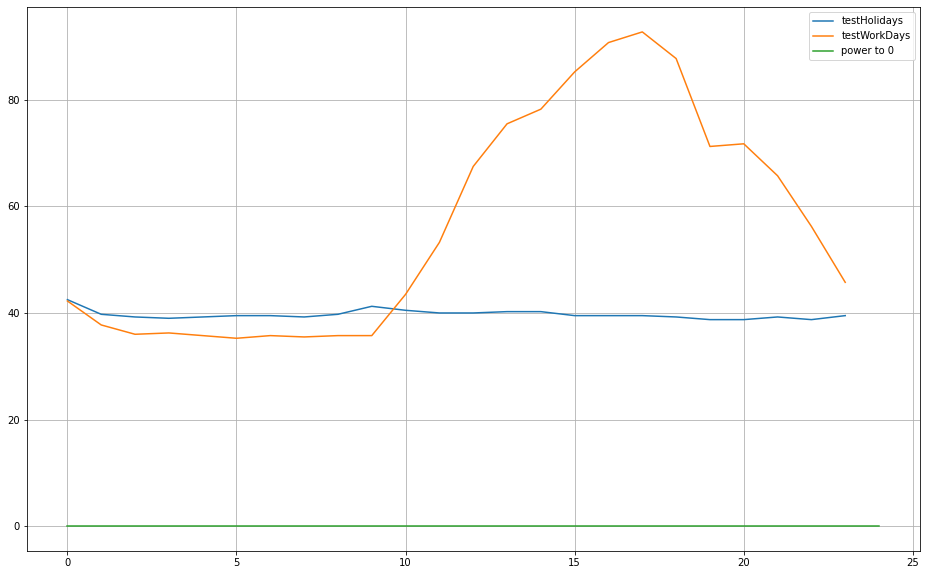

In [20]:
FIG_SIZE = (16,10)
fig, ax = plt.subplots(figsize=FIG_SIZE)
ax.plot([hour for hour in range(24)], testHolidays[0], label='testHolidays')
ax.plot([hour for hour in range(24)], testWorkDays[0], label='testWorkDays')
ax.plot([0,24], [0,0], label='power to 0')
ax.grid()
ax.legend()
plt.show()

Using k-means method to find 3 clusters with the trainingSet

In [21]:
clusters = KMeans(n_clusters=2, random_state=0).fit(allSamples)

numberOfSamples = len(allSamples)
print("number of samples == " +str(numberOfSamples))
print("elements that belong to cluster 0 are :" + str(np.count_nonzero(clusters.labels_ == 0)/numberOfSamples * 100 ) + "%")
print("elements that belong to cluster 1 are :" + str(np.count_nonzero(clusters.labels_ == 1)/numberOfSamples * 100) + "%")
print("elements that belong to cluster 2 are :" + str(np.count_nonzero(clusters.labels_ == 2)/numberOfSamples * 100 ) + "%")

number of samples == 770
elements that belong to cluster 0 are :30.129870129870127%
elements that belong to cluster 1 are :69.87012987012987%
elements that belong to cluster 2 are :0.0%


We know the following dates are not holidays but power demand is low:
- 24/04/2017
- 14/08/2017
- 16/08/2017
- 17/08/2017
- 27/12/2017
- 8/12/2017
- 29/12/2017
- 01/01/2018
- 30/04/2018
- 13/08/2018
- 14/08/2018
- 02/11/2018

Whereas the following dates are holidays but power is high:
- 15/08/2018
- 26/12/2018

In [22]:
print(clusters.predict([trainingSet['2017-04-24']]))
print(clusters.predict([trainingSet['2017-08-14']]))
print(clusters.predict([trainingSet['2017-08-16']]))
print(clusters.predict([trainingSet['2017-08-17']]))
print(clusters.predict([trainingSet['2017-12-27']]))
print(clusters.predict([trainingSet['2017-12-08']]))

[1]
[1]
[1]
[1]
[1]
[1]


Auto encoder with 5 hidden layers[24 ,50 ,20 ,2 , 20, 50, 24].

In [23]:
SIZE_SAMPLE = 24
#enconder
activationMode = 'relu'
encoderInput = keras.Input(shape=SIZE_SAMPLE)
firstLayerEncoder = keras.layers.Dense(50, activation=activationMode)(encoderInput)
secondLayerEncoder = keras.layers.Dense(20, activation=activationMode)(firstLayerEncoder)
encoderOutput = keras.layers.Dense(2, activation=activationMode)(secondLayerEncoder)

#decoder
firstLayerDecoder = keras.layers.Dense(20, activation=activationMode)(secondLayerEncoder)
secondLayerDecoder = keras.layers.Dense(50, activation=activationMode)(firstLayerDecoder)
decoderOutput = keras.layers.Dense(24, activation=activationMode)(secondLayerDecoder)

#auto encoder
autoEncoder = keras.Model(encoderInput, decoderOutput)
autoEncoder.compile(optimizer='Adam', loss='mean_squared_error')
autoEncoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 24)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                1250      
_________________________________________________________________
dense_1 (Dense)              (None, 20)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                1050      
_________________________________________________________________
dense_5 (Dense)              (None, 24)                1224      
Total params: 4,964
Trainable params: 4,964
Non-trainable params: 0
___________________________________________________________

Training model. TRAIN constant is the training set used to train the model: here we use trainingWorkDays which is a set of samples about working days.

In [31]:
TRAIN = trainingWorkDays
BATCH_SIZE = 64
train = np.array(TRAIN)
autoEncoder.fit(train, train, epochs=40, batch_size=BATCH_SIZE, validation_split=0)

Epoch 1/40
7/7 [==============================] - 0s 1ms/step - loss: 473.5896
Epoch 2/40
7/7 [==============================] - 0s 1ms/step - loss: 473.5869
Epoch 3/40
7/7 [==============================] - 0s 1ms/step - loss: 473.5844
Epoch 4/40
7/7 [==============================] - 0s 1ms/step - loss: 473.5844
Epoch 5/40
7/7 [==============================] - 0s 1ms/step - loss: 473.5823
Epoch 6/40
7/7 [==============================] - 0s 1ms/step - loss: 473.5815
Epoch 7/40
7/7 [==============================] - 0s 1ms/step - loss: 473.5824
Epoch 8/40
7/7 [==================

Prediction with auto encoder: in this case the auto encoder is used to detect anomalies during working days.
To see if the auto encoder works properly firstly we can test it with holidaysTests and then with workingDaysTests, so we can compare the scores.

With holidays samples the mse is 17.025769791277636
With working days samples the mse is 27.564548135657898


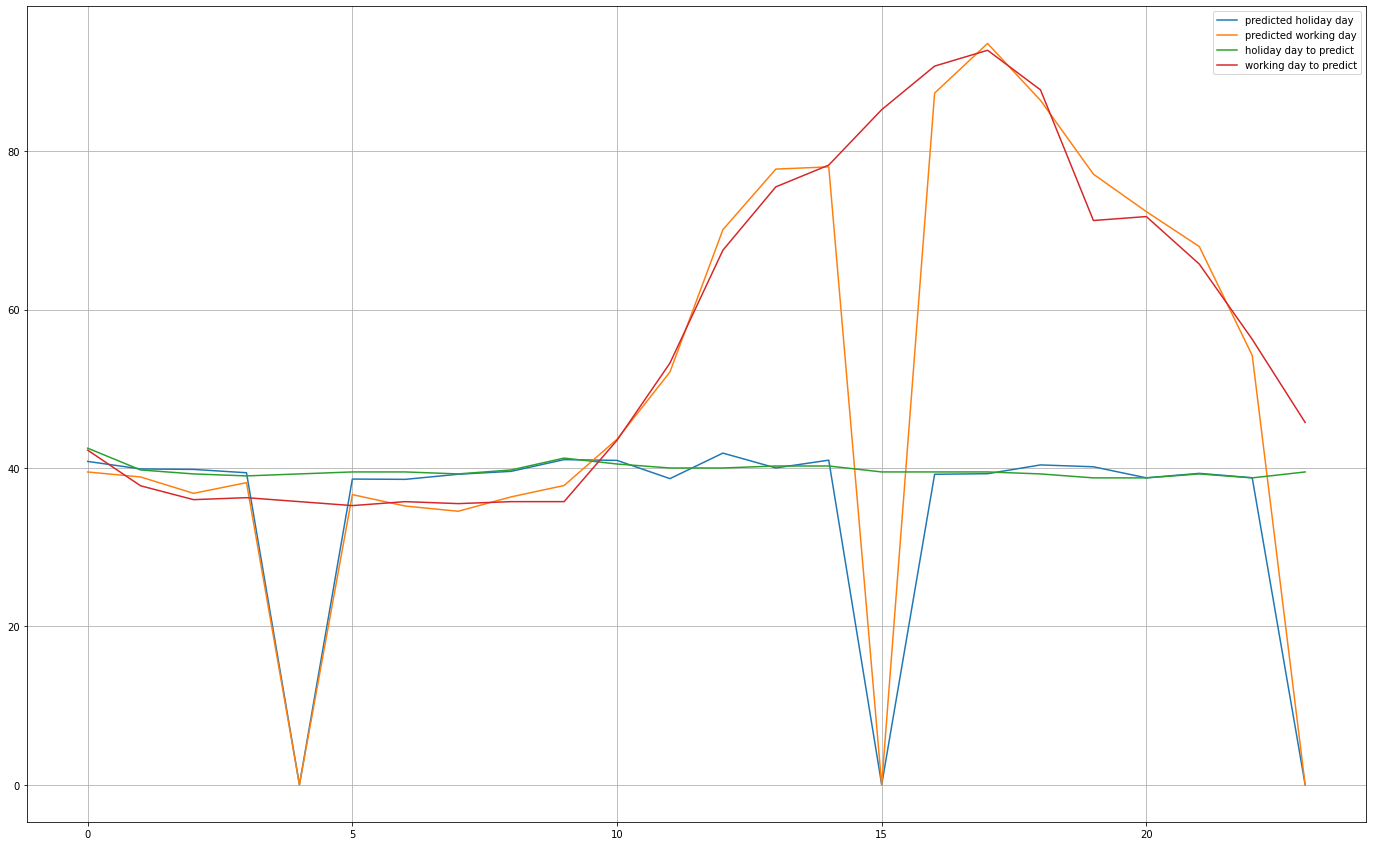

In [32]:
daysToPredict = testHolidays
predictedValue = autoEncoder.predict(daysToPredict)
scoreHolidays = np.sqrt(metrics.mean_squared_error(predictedValue, daysToPredict))

daysToPredict = testWorkDays
predictedValue = autoEncoder.predict(daysToPredict)
scoreWorkingDays = np.sqrt(metrics.mean_squared_error(predictedValue, daysToPredict))

print("With holidays samples the mse is " + str(scoreHolidays))
print("With working days samples the mse is " + str(scoreWorkingDays))

predictedHolidayDay = autoEncoder.predict([testHolidays[0]])[0]
predictedWorkingDay = autoEncoder.predict([testWorkDays[0]])[0]

fig, ax = plt.subplots(figsize=(24,15))
ax.plot([hour for hour in range(24)], predictedHolidayDay, label='predicted holiday day')
ax.plot([hour for hour in range(24)], predictedWorkingDay, label='predicted working day')
ax.plot([hour for hour in range(24)], testHolidays[0], label='holiday day to predict')
ax.plot([hour for hour in range(24)], testWorkDays[0], label='working day to predict')
ax.grid()
ax.legend()
plt.show()


LSTM